## inq python scripts

In [100]:
%%writefile n2-inq.py

import os, sys, subprocess, json
import pinq
import numpy as np
   

def n2_energy(dist):
    print(dist,flush=True)
    path = f'inq-n2-{dist}'
    if not os.path.exists(path): os.mkdir(path)
    result = subprocess.run([f"inq clear; \
        inq theory functional HYB_MGGA_XC_WB97M_V; \
        inq cell cubic 5.0 Angstrom; \
        inq ions insert N {-dist/2} 0.0 0.0 Angstrom; \
        inq ions insert N {dist/2} 0.0 0.0 Angstrom; \
        inq electrons cutoff 40.0 Hartree; \
        inq ground-state mixing 0.1; \
        inq run ground-state"], cwd=path, capture_output=False, shell=True)
    energy = pinq.results.ground_state.energy.total()
    return [dist, energy]

n2_energy(1.1)



Overwriting n2-inq.py


In [39]:
%%writefile n2.py

import os, subprocess, pinq, json
import numpy as np

def n2_energy(dist):
    print(dist,flush=True)
    path = f'inq-n2-{dist}'
    if not os.path.exists(path): os.mkdir(path)
    os.chdir(path)
    # 
    subprocess.run([f"inq clear; \
        inq theory b3lyp; \
        inq cell cubic 5.0 Angstrom; \
        inq ions insert N {-dist/2} 0.0 0.0 Angstrom; \
        inq ions insert N {dist/2} 0.0 0.0 Angstrom; \
        inq electrons cutoff 40.0 Hartree; \
        inq run ground-state"], capture_output=True, shell=True)
    energy = pinq.results.ground_state.energy.total()*627.509474
    os.chdir('..')
    return [dist,energy]

pes = np.asarray([n2_energy(d) for d in np.arange(0.9,1.11,.1)])
pes[:,1] -= np.min(pes[:,1]) 
print(pes)

json_data = {"Dataset": {
    "Data": [{
        "Positions":[[-p[0]/2,0.0,0.0], [p[0]/2,0.0,0.0]], 
        "AtomTypes":['N','N'],
        "Energy": p[1]
    } for p in pes],                     
    "PositionsStyle": "angstrom", 
    "AtomTypeStyle": "chemicalsymbol",
    "EnergyStyle": "kcalmol"}}

with open('N2_ReaxFF.json', 'w') as file:
    json.dump(json_data, file)


Overwriting n2.py


In [123]:
%%writefile n2-parallel-WB97M.py

import concurrent.futures, os, subprocess, pinq, json, threading
import numpy as np

lock = threading.RLock()

def n2_energy(d):
    dist = np.round(d,2)
    path = f'inq-n2-{dist}'
    if not os.path.exists(path): os.mkdir(path)

        #        inq ground-state mixing 0.3; \
        # inq clear;
        
    subprocess.run([f" \
        inq theory functional HYB_MGGA_XC_WB97M_V; \
        inq cell cubic 3.0 Angstrom; \
        inq ions insert N {-dist/2} 0.0 0.0 Angstrom; \
        inq ions insert N {dist/2} 0.0 0.0 Angstrom; \
        inq electrons cutoff 40.0 Hartree; \
        inq ground-state max-steps 500; \
        inq ground-state mixing 0.15; \
        inq species set pseudodojo_pbe_stringent; \
        inq run ground-state"], cwd=path, capture_output=True, shell=True)
    with lock:
        os.chdir(path)
        try:
            energy = pinq.results.ground_state.energy.total()*627.509474
        except:
            energy = np.nan
        os.chdir('..')
    print([dist,energy])
    return [dist,energy]

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = executor.map(n2_energy, np.arange(.9,1.6,.05))
#    results = executor.map(n2_energy, np.arange(1.1,1.11,.05))

pes = np.asarray(list(results))
pes = pes[~np.isnan(pes).any(axis=1)]
pes[:,1] -= np.min(pes[:,1]) 
print(pes)

json_data = {"Dataset": {
    "Data": [{
        "Positions":[[-p[0]/2,0.0,0.0], [p[0]/2,0.0,0.0]], 
        "AtomTypes":['N','N'],
        "Energy": p[1]
    } for p in pes],                     
    "PositionsStyle": "angstrom", 
    "AtomTypeStyle": "chemicalsymbol",
    "EnergyStyle": "kcalmol"}}

with open('N2_ReaxFF-WB97M_V.json', 'w') as file:
    json.dump(json_data, file)

Overwriting n2-parallel-WB97M.py


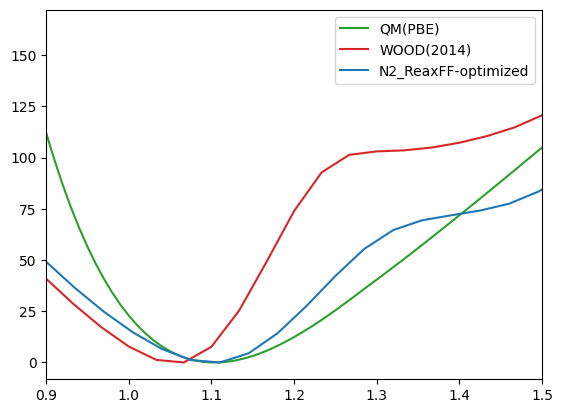

In [166]:
import matplotlib.pyplot as plt
import numpy as np
import json

with open('N2_ReaxFF-PBE.json', 'r') as file:
    pbe = json.load(file)
    pbe_x = [p['Positions'][1][0]-p['Positions'][0][0] for p in pbe['Dataset']['Data']]
    pbe_y = [p['Energy'] for p in pbe['Dataset']['Data']]
   
with open('N2_ReaxFF-HF.json', 'r') as file:
    hf = json.load(file)
    hf_x = [p['Positions'][1][0]-p['Positions'][0][0] for p in hf['Dataset']['Data']]
    hf_y = [p['Energy'] for p in hf['Dataset']['Data']]

wood2014=[[0.8,-149.15230824321474756],
[0.833333333333333,-165.12756673065013047],
[0.866666666666667,-179.84007356536235989],
[0.9,-193.3830398959798913],
[0.933333333333333,-205.81372562328240861],
[0.966666666666667,-217.02449499106089092],
[1,-226.47083119409546725],
[1.03333333333333,-233.00709653445389336],
[1.06666666666667,-234.27353452534666189],
[1.1,-226.59737568652693085],
[1.13333333333333,-209.05503961732711105],
[1.16666666666667,-185.17343223406496122],
[1.2,-160.35569731408088501],
[1.23333333333333,-141.49892789062116094],
[1.26666666666667,-132.94184493159025351],
[1.3,-131.25694357662334255],
[1.33333333333333,-130.73446685880631435],
[1.36666666666667,-129.36676410302067097],
[1.4,-127.0251552553189498],
[1.43333333333333,-123.78179079677200036],
[1.46666666666667,-119.54079832160438457],
[1.5,-113.60780707466594208],
[1.53333333333333,-105.85622776532613898],
[1.56666666666667,-98.273497660996213199],
[1.6,-91.864638906437832588],
[1.63333333333333,-86.550261235710607366],
[1.66666666666667,-82.314329934135031408],
[1.7,-78.870899058868815246],
[1.73333333333333,-75.890719013143964844],
[1.76666666666667,-73.096640749283963601],
[1.8,-70.289190380327269736]]

qeq =[[0.9,-123.44947917966919704],
[0.935,-136.3241140884772733],
[0.97,-147.89432794725567533],
[1.005,-157.943363599871617],
[1.04,-166.0406931785905158],
[1.075,-171.45862986536673134],
[1.11,-172.64699513704402989],
[1.145,-168.16205349762645938],
[1.18,-158.38453045319133139],
[1.215,-145.06775442755804306],
[1.25,-130.40860715702339689],
[1.285,-117.1884960991504272],
[1.32,-108.00123128304242925],
[1.355,-103.23862636411232074],
[1.39,-100.82083638469529774],
[1.425,-98.498733499838266425],
[1.46,-95.169596916967506672],
[1.495,-89.339320923668566365],
[1.53,-81.330816010036130592],
[1.565,-74.964804269625972211],
[1.6,-70.651295983762324227]]

qeq_x = np.transpose(qeq)[0]
qeq_y = np.transpose(qeq)[1] 
qeq_y -= np.min(qeq_y)

acks2_x = np.transpose(acks2)[0]
acks2_y = np.transpose(acks2)[1] 
acks2_y -= np.min(acks2_y)

fig, ax = plt.subplots()
ax.set_xlim([.9,1.5])
ax.plot(pbe_x, pbe_y, color='tab:green')
ax.plot(wood2014_x, wood2014_y,color='tab:red')
ax.plot(qeq_x, qeq_y,color='tab:blue')
ax.legend(['QM(PBE)','WOOD(2014)','N2_ReaxFF-optimized'])
#plt.show()
plt.savefig('N2_reaxFF.png')

## bond scan

In [22]:
%%writefile HF_ReaxFF-bondscan.py

from fitsnap3lib.parallel_tools import ParallelTools
from fitsnap3lib.io.input import Config
from fitsnap3lib.calculators.inq import INQ
import json
import numpy as np

bond_scan = [{
    "Positions":[[-d/2,0.0,0.0], [d/2,0.0,0.0]], 
    "AtomTypes":['H','F']
    } for d in np.arange(0.6,1.401,.05)]

settings = { 
    'CALCULATOR': { 'calculator': 'INQ', 'energy': 1, 'force': 1, 'dipole': 1 },
    'INQ': { 'theory': 'PBE', 'cell': 'cubic 8.0 A finite' }
}

pt = ParallelTools()
config = Config(pt, settings)
inq = INQ('inq', pt, config)
inq.process_configs(bond_scan)

for i, b in enumerate(bond_scan):
    with open(f'JSON/HF/HF_{i}.json', 'w') as json_file:
        json.dump({"Dataset": {"Data": [b]}}, json_file)



Overwriting HF_ReaxFF-bondscan.py


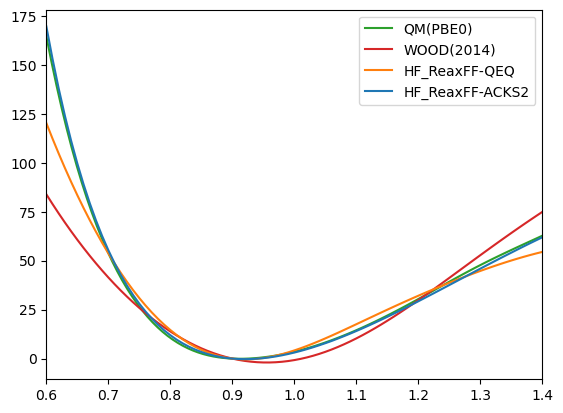

In [59]:
#%%writefile segfault.py

import sys
sys.path.append('/Users/mitch/Dropbox/lammps/FitSNAP-alphataubio')
sys.path.append('/Users/mitch/Dropbox/lammps/lammps-alphataubio/python')

import lammps, os, json
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

def bond_scan(potential, start, stop, step, ground_x, charge_equil='qeq'):
    pes = []
    lmp = lammps.lammps(cmdargs=['-k','on','-sf','kk','-l','none','-sc','none']) 
    #lmp = lammps.lammps(cmdargs=['-k','on','-sf','kk','-l','none']) 
    lmp.command('boundary p p p')
    lmp.command('units real')
    lmp.command('atom_style charge')
    lmp.command('atom_modify map yes')
    lmp.command('region box block -15 15 -15 15 -15 15')
    lmp.command('create_box 7 box')
    lmp.command('pair_style reaxff NULL')
    lmp.command(f'pair_coeff * * {potential} C H O S F Cl N')
    lmp.command('mass * 1.0080')
    lmp.command('mass 5 18.9984')
    lmp.command('mass 7 14.000')
    lmp.command(f'fix 1 all {charge_equil}/reaxff 1 0.0 10.0 1.0e-6 reaxff maxiter 500')
    for dist in np.arange(start, stop, step):
        lmp.command('delete_atoms group all')
        lmp.create_atoms(2, None, [2,5], [-dist/2,0,0,dist/2,0,0])
        lmp.command('run 0 post no')
        pes.append([dist,lmp.get_thermo('pe')])
    lmp.close()
    pes_x, pes_y = np.transpose(pes)
    return pes_x, pes_y - pes_y[(np.abs(pes_x - ground_x)).argmin()]
    
def qm(path):
    pes = []
    with os.scandir(path) as json_files:
        for j in json_files:
            if j.name.endswith('json'):
                with open(j.path, 'r') as file:
                    d = json.load(file)["Dataset"]["Data"][0]
                    pes.append([
                        d['Positions'][1][0]-d['Positions'][0][0],
                        d['Energy']])
                        
    return np.transpose(sorted(pes, key=lambda p: p[0]))

qm_x, qm_y = qm('JSON/HF')
gx = qm_x[np.argmin(qm_y)]

wood2014_x, wood2014_y = bond_scan("reaxff-wood2014.ff", .6, 1.41, .01, gx)

qeq_x,qeq_y=bond_scan("HF_ReaxFF_qeq.ff",.6,1.41,.01,gx,charge_equil='qeq')

acks2_x,acks2_y=bond_scan("HF_ReaxFF_acks2.ff",.6,1.41,.01,gx,charge_equil='acks2')
#acks2e_x,acks2e_y=bond_scan("HF_ReaxFF_acks2e.ff",.6,1.41,.01,gx,charge_equil='acks2')
#print(acks2_y)

x = np.linspace(np.min(qm_x), np.max(qm_x), num=99)
spl = CubicSpline(qm_x, qm_y)

fig, ax = plt.subplots()
ax.set_xlim([.6,1.4])
#ax.set_ylim([-.5,2])
#ax.plot(qm_x, qm_y, color='tab:green')
ax.plot(x, spl(x), color='tab:green')
ax.plot(wood2014_x, wood2014_y,color='tab:red')
ax.plot(qeq_x, qeq_y,color='tab:orange')
ax.plot(acks2_x, acks2_y,color='tab:blue')
#ax.plot(acks2e_x, acks2e_y,color='tab:purple')
ax.legend(['QM(PBE0)','WOOD(2014)','HF_ReaxFF-QEQ','HF_ReaxFF-ACKS2'])
plt.show()

[0.00071607, 0.01850024, 0.03698712, 0.04168559, 0.04278563, 0.04696102, 0.05314201, 0.0599751, 0.0631362, 0.06686835, 0.07332262, 0.07683111, 0.07893503, 0.08330505, 0.08417271, 0.08603157, 0.08664456]


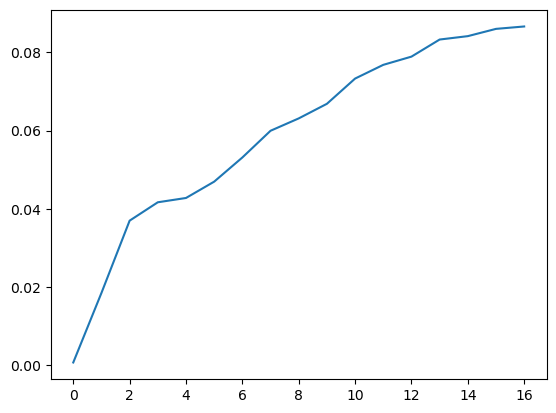

In [44]:
import matplotlib.pyplot as plt

tmp=[0.05314201, 0.08603157, 0.08664456, 0.0599751 , 0.01850024,
       0.04168559, 0.04696102, 0.00071607, 0.0631362 , 0.03698712,
       0.04278563, 0.06686835, 0.07893503, 0.08417271, 0.07683111,
       0.07332262, 0.08330505]

tmp.sort()

print(tmp)

plt.plot(tmp)